In [1]:
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from multiprocessing import Pool
seed = 42

In [2]:
with Pool(100) as p:
    samples = pd.concat(p.map(pd.read_csv, [
        f'./outputs/det_season/realisations_{i+1}_batch_{j+1}.csv'
        for i in range(100)
        for j in range(1000)
    ]))
samples = samples.reset_index()

In [3]:
samples = samples.drop(samples[samples.EIR == -1].index).reset_index()

In [4]:
output_columns = [f'prev_{i}' for i in range(1, 366)]
outputs = samples[output_columns]
features = samples.drop(output_columns + ['init_EIR'], 1)
n_features = len(features.columns)
n_outputs = len(outputs.columns)

/tmp/ipykernel_5127/3418533024.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  features = samples.drop(output_columns + ['init_EIR'], 1)


In [10]:
idx_train, idx_test = train_test_split(
    np.arange(100000),#np.arange(len(outputs)),
    test_size=0.2,
    random_state=seed
)

In [11]:
X_train = features.iloc[idx_train]
y_train = outputs.iloc[idx_train]
X_test = features.iloc[idx_test]
y_test = outputs.iloc[idx_test]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [12]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers

In [13]:
def create_model(
    optimiser='adam',
    n_hidden=3,
    units=512,
    dropout=.1,
    loss='mse',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal'
):
    model = Sequential()
    model.add(layers.Input(shape=(n_features,), dtype='float32'))
    for i in range(n_hidden):
        model.add(layers.Dense(
            units,
            activation=hidden_activation,
            kernel_initializer=hidden_initialiser)
        )
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(n_outputs, activation=output_activation, kernel_initializer=output_initialiser))
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [14]:
model = create_model()
model.fit(X_train, y_train, batch_size=100, epochs=100)

Epoch 1/100
800/800 [==============================] - 3s 3ms/step - loss: 0.0140 - mse: 0.0140
Epoch 2/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0036 - mse: 0.0036
Epoch 3/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0029 - mse: 0.0029
Epoch 4/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0026 - mse: 0.0026
Epoch 5/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0023 - mse: 0.0023
Epoch 6/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0022 - mse: 0.0022
Epoch 7/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0021 - mse: 0.0021
Epoch 8/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0020 - mse: 0.0020
Epoch 9/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0019 - mse: 0.0019
Epoch 10/100
800/800 [==============================] - 2s 3ms/step - loss: 0.0019 - mse: 0.0019
Epoch 11/100
800/800 [=================

In [15]:
y_hat = model.predict(X_test)

6250/6250 [==============================] - 9s 1ms/step


In [21]:
np.mean(y_hat, axis=1).shape

(199982,)

Text(0, 0.5, 'true')

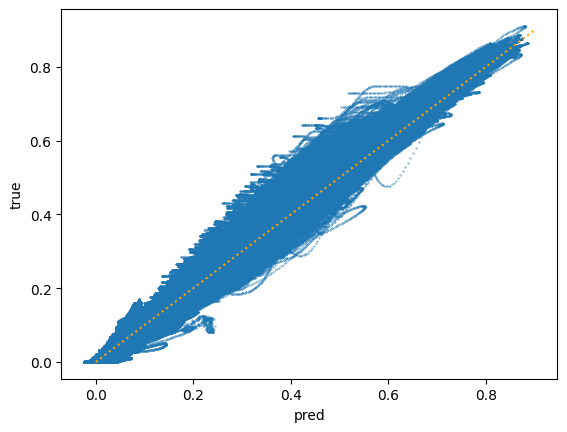

In [24]:
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

Text(0, 0.5, 'true')

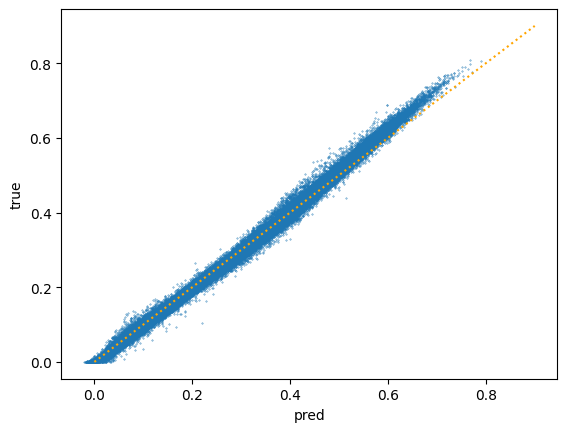

In [22]:
plt.scatter(np.mean(y_hat, axis=1), np.mean(y_test, axis=1), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [12]:
import keras_tuner as kt

In [13]:
def bulid_hypermodel(hp):
    return create_model(
        n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, step=1),
        units = hp.Int("units", min_value=32, max_value=512, step=32),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.01),
        loss = hp.Choice("loss", ['mse', 'log_cosh']),
        hidden_activation = hp.Choice("hidden_activation", ['relu', 'elu']),
        output_activation = hp.Choice("output_activation", ['linear', 'softmax'])
    )

In [14]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="det",
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
output_activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax'], 'ordered': False}


In [16]:
X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [17]:
tuner.search(
    X_hyp_train,
    y_hyp_train,
    validation_data=(X_hyp_val, y_hyp_val),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 230 Complete [00h 02m 17s]
val_mse: 0.00022005359642207623

Best val_mse So Far: 9.33476330828853e-05
Total elapsed time: 02h 25m 44s

Search: Running Trial #231

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
192               |96                |units
0.02              |0                 |dropout
mse               |mse               |loss
elu               |elu               |hidden_activation
linear            |linear            |output_activation
34                |100               |tuner/epochs
12                |34                |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |4                 |tuner/round
0225              |0144              |tuner/trial_id

Epoch 13/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 14/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0023 - 

KeyboardInterrupt: 

623/623 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

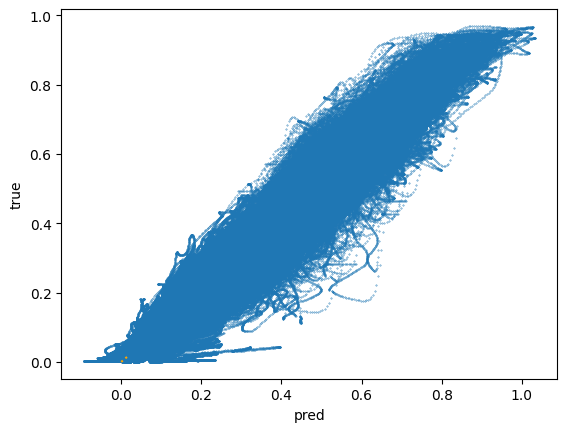

In [38]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.02), np.linspace(0, 0.02), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [39]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 4
units: 128
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.0011498170206323266
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.07
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 0.0012141329934820533
Trial summary
Hyperparameters:
n_hidden: 3
units: 192
dropout: 0.04
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0219
Score: 0.0015096659772098064
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch:

In [15]:
model.save('models/det')

INFO:tensorflow:Assets written to: models/det/assets
